In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *
from venn import venn
import requests
import json

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# DownLoad Allen IDs

Download expression data and discontinued Entrez IDs

http://api.brain-map.org/class_detail/Gene

http://api.brain-map.org/examples/doc/structures/download_data.py.html

http://help.brain-map.org/display/api/Example+Queries+for+Experiment+Metadata

http://api.brain-map.org/doc/DataSet.html

https://ftp.ncbi.nih.gov/gene/README

In [20]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=model::SectionDataSet," +  \
   "rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse']," + \
   "treatments[name$eq'ISH'],genes,plane_of_section," + \
   "rma::options,[tabular$eq'plane_of_sections.name+as+plane'," + \
   "'genes.acronym+as+gene_acronym'," + \
   "'genes.entrez_id+as+genes_entrez_id'," + \
   "'genes.ensembl_id+as+gene_ensembl_id'," + \
   "'genes.alias_tags+as+gene_alias_tags'," + \
   "'data_sets.id+as+section_data_set_id']," + \
   "[order$eq'plane_of_sections.name,genes.acronym,data_sets.id']&" + \
   "start_row=0&num_rows=all"
print(url)
r = requests.get(url, allow_redirects=True)
open('All_Mouse_Brain_ISH_experiments.csv', 'wb').write(r.content)

http://api.brain-map.org/api/v2/data/query.csv?criteria=model::SectionDataSet,rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse'],treatments[name$eq'ISH'],genes,plane_of_section,rma::options,[tabular$eq'plane_of_sections.name+as+plane','genes.acronym+as+gene_acronym','genes.entrez_id+as+genes_entrez_id','genes.ensembl_id+as+gene_ensembl_id','genes.alias_tags+as+gene_alias_tags','data_sets.id+as+section_data_set_id'],[order$eq'plane_of_sections.name,genes.acronym,data_sets.id']&start_row=0&num_rows=all


1569813

In [4]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene," +  \
   "rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse']," + \
   "[tabular$eq'acronym+as+gene_acronym'," + \
   "'gene_aliases.name+as+gene_aliases'," + \
   "'entrez_id+as+genes_entrez_id'," + \
   "[order$eq'acronym']&" + \
   "start_row=0&num_rows=all"
print(url)
r = requests.get(url, allow_redirects=True)
open('All_Mouse_Brain_ISH_genes.csv', 'wb').write(r.content)

http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene,rma::criteria,[failed$eqfalse],products[abbreviation$eq'Mouse'],[tabular$eq'acronym+as+gene_acronym','gene_aliases.name+as+gene_aliases','entrez_id+as+genes_entrez_id',[order$eq'acronym']&start_row=0&num_rows=all


469

In [19]:
url = "http://api.brain-map.org/api/v2/data/query.csv?criteria=" + \
        "model::Gene," + \
        "rma::criteria,products[abbreviation$eq'Mouse']," + \
        "rma::options,[tabular$eq'genes.id','genes.acronym+as+gene_symbol'," + \
        "'genes.name+as+gene_name','genes.entrez_id+as+entrez_gene_id'," + \
        "'genes.homologene_id+as+homologene_group_id'," + \
        "'genes.alias_tags+as+gene_alias_tags']," + \
        "[order$eq'genes.acronym']&num_rows=all&start_row=0"
print(url)
r = requests.get(url, allow_redirects=True)
open('All_Mouse_Brain_Genes.csv', 'wb').write(r.content)

http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Gene,rma::criteria,products[abbreviation$eq'Mouse'],rma::options,[tabular$eq'genes.id','genes.acronym+as+gene_symbol','genes.name+as+gene_name','genes.entrez_id+as+entrez_gene_id','genes.homologene_id+as+homologene_group_id','genes.alias_tags+as+gene_alias_tags'],[order$eq'genes.acronym']&num_rows=all&start_row=0


1737396

# Mouse To Human Mapping

In [2]:
AllenMouseGenes = pd.read_csv("../dat/allen-mouse-exp/All_Mouse_Brain_ISH_experiments.csv")
Human2MouseHom = pd.read_csv("../scripts//HOM_MouseHumanSequence.rpt", delimiter="\t")

In [3]:
Homo_IDs = set(Human2MouseHom["DB Class Key"].values)
print(len(Homo_IDs))

20602


In [4]:
Human2Mouse_Genes = {}
Mouse2Human_Genes = {}
# Key:EntrezID
# symbol: FOXP1
# mouseHomo: [(), ()]
# allen_section_data_set_id: [1,2]
for counter, ID in enumerate(Homo_IDs):
    tmp_df = Human2MouseHom[Human2MouseHom["DB Class Key"]==ID]
    #print(tmp_df)   
    hum_genes, mou_genes = [], []
    for i, row in tmp_df.iterrows():
        TaxonID = row["NCBI Taxon ID"]
        Symbol = row["Symbol"]
        Entrez = row["EntrezGene ID"]
        if  TaxonID == 9606:
            hum_genes.append((Symbol, Entrez))
        elif TaxonID == 10090:
            mou_genes.append((Symbol, Entrez))
    # Fill up Human2Mouse_Genes
    for (Symbol, Entrez) in hum_genes:
        if Entrez not in Human2Mouse_Genes:
            Human2Mouse_Genes[Entrez] = {}#mou_genes
            Human2Mouse_Genes[Entrez]["symbol"] = Symbol
            Human2Mouse_Genes[Entrez]["mouseHomo"] = mou_genes
        else:
            Human2Mouse_Genes[Entrez]["mouseHomo"].extend(mou_genes)
        
    # Fill up Mouse2Human_Genes
    for (Symbol, Entrez) in mou_genes:
        if Entrez not in Mouse2Human_Genes:
            Mouse2Human_Genes[Entrez] = {} #mou_genes
            Mouse2Human_Genes[Entrez]["symbol"] = Symbol
            Mouse2Human_Genes[Entrez]["humanHomo"] = hum_genes
            Mouse2Human_Genes[Entrez]["allen_section_data_set_id"] = []
        else:
            Mouse2Human_Genes[Entrez]["humanHomo"].extend(hum_genes)
            

In [6]:
Mouse2Human_Genes_2 = {}
for k,v in Mouse2Human_Genes.items():
    Mouse2Human_Genes_2[v["symbol"]] = {}
    Mouse2Human_Genes_2[v["symbol"]]["Entrez"] = k
    Mouse2Human_Genes_2[v["symbol"]]["humanHomo"] = v["humanHomo"]

In [12]:
pk.dump(Mouse2Human_Genes_2, open("../../data/Mouse2Human_Symbol.pk", "wb"))
pk.dump(Mouse2Human_Genes, open("../../data/Mouse2Human_Entrez.pk", "wb"))

In [10]:
Discontinued_ID = {}
df = pd.read_csv("..//dat/genes/gene_history.human.mouse.tsv", delimiter="\t")
Discontinued_ID = dict(zip(df["Discontinued_GeneID"].values, df["GeneID"].values))


In [15]:
# Match Allen section_id to mouse genes with Entrez ID
def MatchAllen(symbol, entrez, row):
    # row: plane,gene_acronym,genes_entrez_id,gene_ensembl_id,gene_alias_tags,section_data_set_id
    #print(symbol, entrez)
    #print(row["gene_acronym"], row["genes_entrez_id"], row["gene_alias_tags"] )
    if str(row["genes_entrez_id"]) != "nan" and int(entrez) == int(row["genes_entrez_id"]):
        return row["section_data_set_id"]
    elif symbol == row["gene_acronym"]:
        return row["section_data_set_id"]
    else:
        if str(row["gene_alias_tags"]) == "nan":
            #print("haha")
            return None
        #print(str(row["gene_alias_tags"]), type(row["gene_alias_tags"]))
        for alias in row["gene_alias_tags"].split():
            alias = alias.strip()
            if alias == symbol:
                return row["section_data_set_id"]
    return None

Entrez_Failed_ID = []
for i, row in AllenMouseGenes.iterrows():
    if row["section_data_set_id"] == 68269058:
        print(row)
    if str(row["gene_acronym"]) != "nan":
        allen_symbol = row["gene_acronym"]
    else:
        allen_symbol = None
    if str(row["genes_entrez_id"]) != "nan":
        allen_entrez = int(row["genes_entrez_id"])
    else:
        allen_entrez = None
    if str(row["gene_alias_tags"]) != "nan":
        allen_alias = row["gene_alias_tags"].split()
    else:
        allen_alias = []
    allen_section_id = row["section_data_set_id"]
    try:
        potential_ID = int(Discontinued_ID[allen_entrez])
    except:
        potential_ID = -1
        pass
    if allen_entrez in Mouse2Human_Genes:
        Mouse2Human_Genes[allen_entrez]["allen_section_data_set_id"].append(allen_section_id)
    elif potential_ID in Mouse2Human_Genes:
        Mouse2Human_Genes[potential_ID]["allen_section_data_set_id"].append(allen_section_id)
    else:    
        Entrez_Failed_ID.append(allen_section_id)
 

plane                                sagittal
gene_acronym                            Spsb2
genes_entrez_id                       14794.0
gene_ensembl_id                           NaN
gene_alias_tags        AI461677 C9 Grcc9 SSB2
section_data_set_id                  68269058
Name: 22657, dtype: object


In [16]:
Mouse2Human_Genes[18430]

{'symbol': 'Oxtr',
 'humanHomo': [('OXTR', 5021)],
 'allen_section_data_set_id': [75081001, 78153167]}

In [130]:
68269058 in Entrez_Failed_ID

False

In [131]:
Mouse2Human_Genes

{14573: {'symbol': 'Gdnf',
  'humanHomo': [('GDNF', 2668)],
  'allen_section_data_set_id': [112647321, 69672862]},
 20845: {'symbol': 'Star',
  'humanHomo': [('STAR', 6770)],
  'allen_section_data_set_id': [69887325]},
 57265: {'symbol': 'Fzd2',
  'humanHomo': [('FZD2', 2535)],
  'allen_section_data_set_id': [81654103]},
 15396: {'symbol': 'Hoxa11',
  'humanHomo': [('HOXA11', 3207)],
  'allen_section_data_set_id': [69289135]},
 109663: {'symbol': 'Hoxc11',
  'humanHomo': [('HOXC11', 3227)],
  'allen_section_data_set_id': [81790682, 75990865]},
 640524: {'symbol': 'Sptbn5',
  'humanHomo': [('SPTBN5', 51332)],
  'allen_section_data_set_id': []},
 216049: {'symbol': 'Zfp365',
  'humanHomo': [('ZNF365', 22891)],
  'allen_section_data_set_id': [73929873, 70200776]},
 68980: {'symbol': 'Wdr53',
  'humanHomo': [('WDR53', 348793)],
  'allen_section_data_set_id': [68637461]},
 624784: {'symbol': 'Tdg-ps2',
  'humanHomo': [('TDG', 6996)],
  'allen_section_data_set_id': []},
 21665: {'symbol': 'T

In [132]:
print(len(Entrez_Failed_ID))

2718


In [133]:
# Check missed by entrez ID
Mouse_MissSectionID = []
for K, V in Mouse2Human_Genes.items():
    if len(V["allen_section_data_set_id"]) == 0:
        Mouse_MissSectionID.append(K)
print(len(Mouse_MissSectionID))

3393


In [135]:
Unlinked_AllenMouseGenes[Unlinked_AllenMouseGenes["section_data_set_id"]==70787630]

,plane,gene_acronym,genes_entrez_id,gene_ensembl_id,gene_alias_tags,section_data_set_id


In [134]:
Unlinked_AllenMouseGenes = AllenMouseGenes[AllenMouseGenes["section_data_set_id"].isin(
    Entrez_Failed_ID)]
Symbol_Failed_ID = []
Mapped_by_symbol = 0
Mapped_by_alias = 0
for i, row in Unlinked_AllenMouseGenes.iterrows():
    if row["section_data_set_id"] == 68269058:
        print(row)
    if str(row["gene_acronym"]) != "nan":
        allen_symbol = row["gene_acronym"]
    else:
        allen_symbol = None
    if str(row["gene_alias_tags"]) != "nan":
        allen_alias = row["gene_alias_tags"].split()
    else:
        allen_alias = []
    allen_section_id = row["section_data_set_id"]
    FLAG_FIND = False
    for k in Mouse_MissSectionID:
        symbol = Mouse2Human_Genes[k]["symbol"]
        if symbol.lower() == allen_symbol.lower():
            Mouse2Human_Genes[k]["allen_section_data_set_id"].append(allen_section_id)
            FLAG_FIND = True
            Mapped_by_symbol += 1
            break
        else:
            for alias in allen_alias:
                if alias == "C9":
                    print(row)
                if alias.lower() == symbol.lower():
                    Mouse2Human_Genes[k]["allen_section_data_set_id"].append(allen_section_id)
                    FLAG_FIND = True
                    Mapped_by_alias += 1
                    print(alias)
                    break
    if not FLAG_FIND:
        Symbol_Failed_ID.append(allen_section_id)
print(Mapped_by_symbol, Mapped_by_alias)
print(len(Symbol_Failed_ID))

Nrbf2
TRDV4
Ndufs5
Ndufs5
A930017K11Rik
5530400C23Rik
Nrbf2
Abcb5
Ddx23
Atp8b4
Myo18b
Sp5
Pramel5
1 13
2704


In [14]:
Unlinked_AllenMouseGenes = AllenMouseGenes[AllenMouseGenes["section_data_set_id"].isin(
    Symbol_Failed_ID)]

In [15]:
Unlinked_AllenMouseGenes

,plane,gene_acronym,genes_entrez_id,gene_ensembl_id,gene_alias_tags,section_data_set_id
6,coronal,1200016E24Rik,319202.0,NaN,NaN,1591
13,coronal,2610028E06Rik,72395.0,NaN,BB043107,71020430
15,coronal,3100002H09Rik,70249.0,NaN,NaN,77340484
19,coronal,4833414E09Rik,71633.0,NaN,AI593012,73521828
26,coronal,5330421K23Rik*,NaN,NaN,NaN,75043138
...,...,...,...,...,...,...
25955,sagittal,Zfp955a,77652.0,NaN,A430003O12Rik AI842447 C430039G02Rik C530035A1...,71210971
25990,sagittal,Zim2,76637.0,NaN,1700116N21Rik,71920213
26021,sagittal,Znf41-ps,70005.0,NaN,NaN,69134250
26056,sagittal,Zscan4a,434555.0,NaN,BQ559217 LOC434555 XM_486399,68667234


In [16]:
DIR = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/"
with open(DIR + 'human2mouse.0420.json', 'w') as outfile:
    json.dump(Human2Mouse_Genes, outfile)
with open(DIR + 'mouse2sectionID.0420.json', 'w') as outfile:
    json.dump(Mouse2Human_Genes, outfile)
Unlinked_AllenMouseGenes.to_csv(DIR + "Allen_Unlinked_SectionIDs.0415.csv", index=False)

In [17]:
Mouse2Human_Genes

{14573: {'symbol': 'Gdnf',
  'humanHomo': [('GDNF', 2668)],
  'allen_section_data_set_id': [112647321, 69672862]},
 20845: {'symbol': 'Star',
  'humanHomo': [('STAR', 6770)],
  'allen_section_data_set_id': [69887325]},
 57265: {'symbol': 'Fzd2',
  'humanHomo': [('FZD2', 2535)],
  'allen_section_data_set_id': [81654103]},
 15396: {'symbol': 'Hoxa11',
  'humanHomo': [('HOXA11', 3207)],
  'allen_section_data_set_id': [69289135]},
 109663: {'symbol': 'Hoxc11',
  'humanHomo': [('HOXC11', 3227)],
  'allen_section_data_set_id': [81790682, 75990865]},
 640524: {'symbol': 'Sptbn5',
  'humanHomo': [('SPTBN5', 51332)],
  'allen_section_data_set_id': []},
 216049: {'symbol': 'Zfp365',
  'humanHomo': [('ZNF365', 22891)],
  'allen_section_data_set_id': [73929873, 70200776]},
 68980: {'symbol': 'Wdr53',
  'humanHomo': [('WDR53', 348793)],
  'allen_section_data_set_id': [68637461]},
 624784: {'symbol': 'Tdg-ps2',
  'humanHomo': [('TDG', 6996)],
  'allen_section_data_set_id': []},
 21665: {'symbol': 'T

In [18]:
Mouse_MissSectionID = []
for K, V in Mouse2Human_Genes.items():
    if len(V["allen_section_data_set_id"]) == 0:
        Mouse_MissSectionID.append(K)
print(len(Mouse_MissSectionID))

3381


In [69]:
#xx = json.load(open(DIR + "mouse2sectionID.0415.json"))
#yy = json.load(open(DIR + "human2mouse.0415.json"))

# Expression Level Mat construction

In [152]:
STR_Meta = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/allen_brain_atlas_structures.csv")
STR_Meta.dropna(inplace=True, subset=["atlas_id"])
STR_Meta["atlas_id"] = STR_Meta["atlas_id"].astype(int)
#STR_Meta["parent_structure_id"] = STR_Meta["parent_structure_id"].astype(int)
STR_Meta = STR_Meta.set_index("atlas_id")
for i, row in STR_Meta.iterrows():
    STR_Meta.loc[i, "Name2"] = modify_str(row["safe_name"])


In [153]:
STR_Meta[STR_Meta["depth"]==0]

,id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,graph_id,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,Name2
atlas_id,,,,,,,,,,,,,,,,,,,,,
-1,997,root,root,0,1,3,8690,NaN,0,1,...,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root,root


In [154]:
Selected_STRs = LoadList("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/Structures.txt")

In [155]:
STR_Meta_2 = STR_Meta[STR_Meta["Name2"].isin(Selected_STRs)]
STR_Meta_2 = STR_Meta_2.sort_values("Name2")
STR_Meta_2.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/Selected_213_STRs.Meta.csv")

In [156]:
STR_Meta_2.head(2)

,id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,graph_id,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,Name2
atlas_id,,,,,,,,,,,,,,,,,,,,,
18,151,Accessory olfactory bulb,AOB,8,1,3,8690,698.0,6,1,...,/997/8/567/688/695/698/151/,9DF0D2,NaN,NaN,f,387,3386724067,734881840,Accessory olfactory bulb,Accessory_olfactory_bulb
12,104,"Agranular insular area, dorsal part",AId,9,1,3,8690,95.0,7,1,...,/997/8/567/688/695/315/95/104/,219866,NaN,NaN,f,280,289370996,734881840,Agranular insular area dorsal part,Agranular_insular_area_dorsal_part


In [157]:
Count1, Count2, Count3 = 0,0,0
for K, V in Mouse2Human_Genes.items():
    Count1 += 1
    #print(V)
    if len(V["humanHomo"])>0:
        Count2 += 1
    if len(V["allen_section_data_set_id"]) > 0:
        Count3 += 1
print(Count1, Count2, Count3)

20600 19545 17219


In [158]:
# Check Human Genes
Count1, Count2, Count3 = 0,0,0
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Count1 += 1
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    if len(mouseHomo) > 0:
        Count2 += 1
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"] 
        g_All_Section_ID.extend(section_ids)
    #PRINT(g_All_Section_ID)
    if len(g_All_Section_ID) > 0:
        Count3 += 1
print(Count1, Count2, Count3)

18981 18980 17196


In [159]:
18981  - 16820

2161

In [160]:
# Check Exp Level Cross Expriments
DataDIR = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/"
All_Genes = []
All_ExpEnergy = []
Counts = 0

Exp1 = []
Exp2 = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    if len(g_All_Section_ID) <= 1:
        continue
    try:
        g_All_dat = []
        for section in g_All_Section_ID:
            dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
            _ = dat_df[dat_df["structure_id"]==997]
            if len(_) > 0:
                exp_energy = _["expression_energy"].values[0]
                g_All_dat.append(exp_energy)
            else:
                continue
        #print(entrez, Symbol, v["mouseHomo"], g_All_Section_ID)
        #print(g_All_dat)
        if len(g_All_dat)>=2:
            Exp1.append(g_All_dat[0])
            Exp2.append(g_All_dat[1])
    except:
        print("Err", entrez)
    Counts += 1
    #if Counts > 1000:
    #    break


In [161]:
print(len(Exp1), len(Exp2))

5489 5489


(0.7568554944325647, 0.0)


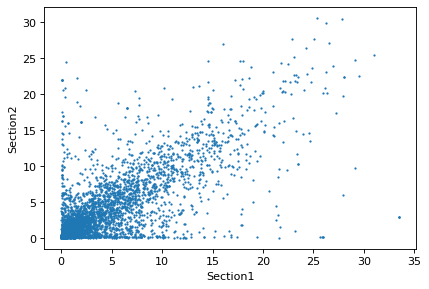

In [162]:
plt.scatter(Exp1, Exp2, s=1)
plt.xlabel("Section1")
plt.ylabel("Section2")
print(pearsonr(Exp1, Exp2))

In [257]:
# Get Root Expression
# Check Exp Level Cross Expriments
DataDIR = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/"
All_Genes = []
All_ExpEnergy = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    g_All_dat = []
    for section in g_All_Section_ID:
        dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
        _ = dat_df[dat_df["structure_id"]==997]
        if len(_) > 0:
            exp_energy = _["expression_energy"].values[0]
            g_All_dat.append(exp_energy)
    g_avg_exp_energy = np.nanmean(g_All_dat)
    All_ExpEnergy.append(g_avg_exp_energy)
All_ExpEnergy = np.array(All_ExpEnergy)    
        

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [260]:
print(len(All_ExpEnergy), len(Human2Mouse_Genes.keys()))

18981 18981


In [262]:
df = pd.DataFrame(data={"Genes":list(Human2Mouse_Genes.keys()), "EXP":All_ExpEnergy})
df = df.dropna(subset=["EXP"])
df.shape

(17189, 2)

In [263]:
df.to_csv("ExpMatchFeatures.csv", index=False)

In [193]:
All_ExpEnergy

array([8.7953965, 0.750938 , 0.240475 , ..., 0.147651 , 0.393516 ,
       6.5018495])

In [164]:
DataDIR = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/allen-mouse-brain-altas-str-unionzed/"
All_Genes = []
All_ExpEnergy = []
for i, (entrez, v) in enumerate(Human2Mouse_Genes.items()):
    Symbol = v["symbol"]
    mouseHomo = v["mouseHomo"]
    g_All_Section_ID = []
    for m_symbol, m_entrez in mouseHomo:
        section_ids = Mouse2Human_Genes[m_entrez]["allen_section_data_set_id"]
        g_All_Section_ID.extend(section_ids)
    #print(g_All_Section_ID)
    g_All_dat = []
    if len(g_All_Section_ID) <= 0:
        continue
    for section in g_All_Section_ID:
        #print(section)
        dat_df = pd.read_csv("{}/{}.csv".format(DataDIR, section))
        #print(dat_df)
        dat = []
        for str_id, row in STR_Meta_2.iterrows():
            _id = row["id"]
            _ = dat_df[dat_df["structure_id"]==_id]
            if len(_) > 0:
                exp_energy = np.log2(1+_["expression_energy"].values[0])
            else:
                exp_energy = np.nan
                
            dat.append(exp_energy)
        g_All_dat.append(dat)
    g_All_dat = np.array(g_All_dat)
    #print(g_All_dat)
    
    g_avg_exp_energy = np.nanmean(g_All_dat, axis=0)
    #print(g_avg_exp_energy)
    
    All_Genes.append(entrez)
    All_ExpEnergy.append(g_avg_exp_energy)
    
All_ExpEnergy = np.array(All_ExpEnergy)    


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


In [165]:
ExpMat = pd.DataFrame(data=All_ExpEnergy, index=All_Genes, columns=STR_Meta_2["Name2"].values)


In [166]:
ExpMat2 = ExpMat.dropna(axis=0, how='all', inplace=False)
print(ExpMat2.shape, ExpMat.shape)

(17189, 213) (17196, 213)


In [167]:
print(All_ExpEnergy.shape)

(17196, 213)


In [168]:
ExpMat.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.0418.csv")

In [169]:
ExpMat = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.0418.csv", index_col=0)

# Compare Human gene 2 section ID mapping with Jon

In [77]:
Human2Sec = {}
counts = 0
for K,V in Human2Mouse_Genes.items():
    counts += 1
    secs = []
    for v in V["mouseHomo"]:
        mk = v[1]
        
        xx = Mouse2Human_Genes[mk]["allen_section_data_set_id"]
        secs.extend(xx)
    if len(secs) > 0:
        Human2Sec[K] = secs

In [61]:
f = "/Users/jiayao/Work/ASD_Circuits/src/dat/Jon_data/gene_to_sectiondataset_mapping.csv"
JonMap = {}
with open(f, 'r') as fin:
    for l in fin.readlines():
        if l.startswith('"human.entrez"'):
            continue
        xx = l.strip().split(",")
        _id = int(xx[0].strip('"'))
        secs = [int(x) for x in xx[1].strip('"').split("|")]
        JonMap[_id] = secs

In [78]:
JW_ks = set(Human2Sec.keys())
JC_ks = set(JonMap.keys())
print(len(JW_ks.intersection(JC_ks)))

17173


In [79]:
print(len(JW_ks.difference(JC_ks)))
JW_ks.difference(JC_ks)

23


{278,
 1667,
 1668,
 1670,
 2939,
 5645,
 7310,
 10878,
 28517,
 51807,
 54753,
 81851,
 83895,
 93349,
 118670,
 154754,
 162966,
 221357,
 280657,
 280659,
 280660,
 390084,
 100137047}

In [90]:
ID = 278
print(Human2Sec[ID])
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    if len(Mouse2Human_Genes[v[1]]["allen_section_data_set_id"]) > 0:
        print(Mouse2Human_Genes[v[1]])

[69526611]
{'symbol': 'AMY1C', 'mouseHomo': [('Amy1', 11722), ('Amy2a5', 109959)]}
{'symbol': 'Amy2a5', 'humanHomo': [('AMY1B', 277), ('AMY2A', 279), ('AMY2B', 280)], 'allen_section_data_set_id': [69526611]}


In [120]:
JonMap[278]

KeyError: 278

In [86]:
ID = 1667
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    print(Mouse2Human_Genes[v[1]])

{'symbol': 'DEFA1', 'mouseHomo': [('Defa41', 100041759), ('Defa23', 497114), ('Defa23', 497114), ('Defa23', 497114), ('Defa37', 100041895), ('Defa37', 100041895), ('Defa37', 100041895), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa3', 13237), ('Defa3', 13237), ('Defa3', 13237), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa24

In [89]:
ID = 1668
print(Human2Sec[ID])
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    if len(Mouse2Human_Genes[v[1]]["allen_section_data_set_id"]) > 0:
        print(Mouse2Human_Genes[v[1]])

[71991708, 71991708]
{'symbol': 'DEFA3', 'mouseHomo': [('Defa41', 100041759), ('Defa23', 497114), ('Defa23', 497114), ('Defa23', 497114), ('Defa37', 100041895), ('Defa37', 100041895), ('Defa37', 100041895), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa26', 626708), ('Defa3', 13237), ('Defa3', 13237), ('Defa3', 13237), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa32', 100041890), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa40', 100041787), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa28', 626682), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa35', 100041688), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa30', 100038927), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34', 100041952), ('Defa34',

In [80]:
JC_ks.difference(JW_ks)

{735,
 3892,
 4116,
 4583,
 4869,
 5438,
 6010,
 6289,
 7314,
 7316,
 7795,
 10081,
 23467,
 26693,
 30837,
 50506,
 50700,
 50831,
 56129,
 60559,
 79345,
 84432,
 90226,
 125206,
 162517,
 283455,
 388743,
 100093630,
 100124696,
 100187828,
 100505381,
 100652885,
 100861412,
 102157402}

In [118]:
ID = 735
print(JonMap[ID])
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    #if len(Mouse2Human_Genes[v[1]]["allen_section_data_set_id"]) > 0:
    print(Mouse2Human_Genes[v[1]])

[68269058]
{'symbol': 'C9', 'mouseHomo': [('C9', 12279)]}
{'symbol': 'C9', 'humanHomo': [('C9', 735)], 'allen_section_data_set_id': []}


In [115]:
ID = 84727
print(JonMap[ID])
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    #if len(Mouse2Human_Genes[v[1]]["allen_section_data_set_id"]) > 0:
    print(Mouse2Human_Genes[v[1]])

[68269058]
{'symbol': 'SPSB2', 'mouseHomo': [('Spsb2', 14794)]}
{'symbol': 'Spsb2', 'humanHomo': [('SPSB2', 84727)], 'allen_section_data_set_id': [68269058, 68269058]}


In [97]:
ID = 102157402
print(JonMap[ID])
print(Human2Mouse_Genes[ID])
for v in Human2Mouse_Genes[ID]["mouseHomo"]:
    #if len(Mouse2Human_Genes[v[1]]["allen_section_data_set_id"]) > 0:
    print(Mouse2Human_Genes[v[1]])

[68341890]
{'symbol': 'AK6', 'mouseHomo': [('Ak6', 102216272)]}
{'symbol': 'Ak6', 'humanHomo': [('AK6', 102157402)], 'allen_section_data_set_id': []}


In [119]:
Mouse2Human_Genes[108143]

{'symbol': 'Taf9',
 'humanHomo': [('TAF9', 6880)],
 'allen_section_data_set_id': [68341890, 81654147, 68341890, 81654147]}

In [68]:
Human2Mouse_Genes

{2668: {'symbol': 'GDNF', 'mouseHomo': [('Gdnf', 14573)]},
 6770: {'symbol': 'STAR', 'mouseHomo': [('Star', 20845)]},
 2535: {'symbol': 'FZD2', 'mouseHomo': [('Fzd2', 57265)]},
 3207: {'symbol': 'HOXA11', 'mouseHomo': [('Hoxa11', 15396)]},
 3227: {'symbol': 'HOXC11', 'mouseHomo': [('Hoxc11', 109663)]},
 51332: {'symbol': 'SPTBN5', 'mouseHomo': [('Sptbn5', 640524)]},
 22891: {'symbol': 'ZNF365', 'mouseHomo': [('Zfp365', 216049)]},
 348793: {'symbol': 'WDR53', 'mouseHomo': [('Wdr53', 68980)]},
 6996: {'symbol': 'TDG', 'mouseHomo': [('Tdg-ps2', 624784), ('Tdg', 21665)]},
 286753: {'symbol': 'TRARG1', 'mouseHomo': [('Trarg1', 237858)]},
 5155: {'symbol': 'PDGFB', 'mouseHomo': [('Pdgfb', 18591)]},
 29909: {'symbol': 'GPR171', 'mouseHomo': [('Gpr171', 229323)]},
 389396: {'symbol': 'GLYATL3', 'mouseHomo': [('Glyatl3', 435528)]},
 10249: {'symbol': 'GLYAT', 'mouseHomo': [('Keg1', 64697), ('Glyat', 107146)]},
 9112: {'symbol': 'MTA1', 'mouseHomo': [('Mta1', 116870)]},
 64321: {'symbol': 'SOX17

# Compare Expression level with Jon's data

In [189]:
#JW_ExpMat_log = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/JW.ExpMat.log2.csv", index_col=0)
#JW_ExpMat_nolog = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.0418.csv", index_col=0)
JW_ExpMat_nolog = pd.read_csv("ExpLevel.csv", index_col=0)
Jon_ExpMat = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/src/dat/Jon_data/expression_energy-human-connectome_struc.csv", index_col=0)


In [178]:
# Normalize
ExpMat1 = JW_ExpMat_nolog.copy(deep=True)
for c in ExpMat1.columns.values:
    ExpMat1[c] = np.log2(1+ExpMat1[c])
#ExpMat1 = quantileNormalize(ExpMat1)
ExpMat1.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/ExpLevel.csv")

ExpMat2 = Jon_ExpMat.copy(deep=True)
for c in ExpMat2.columns.values:
    ExpMat2[c] = np.log2(1+ExpMat2[c])
#ExpMat2 = quantileNormalize(ExpMat2)
ExpMat2.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/JC_ExpMat.ArithmeticMean.qn.0418.csv")

ExpMat3 = JW_ExpMat_log.copy(deep=True)
#xpMat3 = quantileNormalize(ExpMat3)
ExpMat3.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/JW_ExpMat.LogMean.qn.0418.csv")



In [138]:
#26078 files 26079 entries 
Human2Mouse_Genes[6658]

{'symbol': 'SOX3', 'mouseHomo': [('Sox3', 20675)]}

In [139]:
Mouse2Human_Genes[20675]

{'symbol': 'Sox3',
 'humanHomo': [('SOX3', 6658)],
 'allen_section_data_set_id': [81655552]}

In [190]:
JW_ExpMat_genes = set(JW_ExpMat_nolog.index.values)
Jon_ExpMat_genes = set(Jon_ExpMat.index.values)

### compare gene difference

In [191]:
JW_ExpMat_genes.difference(Jon_ExpMat_genes)

{1757,
 2313,
 3196,
 4725,
 6658,
 9124,
 9416,
 28517,
 29982,
 51365,
 55723,
 79895,
 84700,
 146325,
 340273,
 389058}

In [192]:
Jon_ExpMat_genes.difference(JW_ExpMat_genes)

{1564,
 1669,
 3447,
 3889,
 3892,
 3933,
 6166,
 7561,
 7576,
 7795,
 11025,
 23547,
 26341,
 79289,
 85290,
 85349,
 135250,
 158431,
 163051,
 163059,
 170482,
 100124696,
 100130932,
 100132015,
 100132386,
 100187828,
 100505381,
 100652885}

In [176]:
List2Fil(list(JW_ExpMat_genes.difference(Jon_ExpMat_genes)), "Jw.diff.Jc.txt")
List2Fil(list(Jon_ExpMat_genes.difference(JW_ExpMat_genes)), "Jc.diff.Jw.txt")

In [197]:
xx_id = 84700
xx = Human2Mouse_Genes[xx_id]
print(xx)
xx = Mouse2Human_Genes[xx['mouseHomo'][0][1]]
print(xx)

{'symbol': 'MYO18B', 'mouseHomo': [('Myo18b', 74376)]}
{'symbol': 'Myo18b', 'humanHomo': [('MYO18B', 84700)], 'allen_section_data_set_id': [74427049]}


In [205]:
xx_id = 1564
xx = Human2Mouse_Genes[xx_id]
print(xx)
xx = Mouse2Human_Genes[xx['mouseHomo'][0][1]]
print(xx)

{'symbol': 'CYP2D7', 'mouseHomo': [('Cyp2d22', 56448)]}
{'symbol': 'Cyp2d22', 'humanHomo': [('CYP2D6', 1565), ('CYP2D7', 1564)], 'allen_section_data_set_id': []}


In [212]:
JonMap[1564]

KeyError: 1564

In [213]:
JonMap[100124696]

[68162243]

In [216]:
JonMap[7006]

[68162243]

In [214]:
Mouse2Human_Genes[21682]

{'symbol': 'Tec',
 'humanHomo': [('TEC', 7006)],
 'allen_section_data_set_id': [68162243]}

In [215]:
Human2Mouse_Genes[100124696]

KeyError: 100124696

In [209]:
print(len(JonMap), len(Jon_ExpMat_genes))

17207 17208


In [75]:
len(Jon_ExpMat_genes.difference(JW_ExpMat_genes))

65

In [76]:
Jon_ExpMat_genes.difference(JW_ExpMat_genes)

{240,
 730,
 1041,
 4515,
 4586,
 4858,
 5375,
 9330,
 9398,
 9717,
 10395,
 22979,
 25788,
 25981,
 26033,
 54492,
 56163,
 56171,
 57558,
 57644,
 63895,
 64420,
 64745,
 85452,
 90381,
 91050,
 113146,
 114784,
 124602,
 126859,
 128239,
 131405,
 140832,
 145389,
 158401,
 166379,
 166863,
 199974,
 221264,
 245929,
 256158,
 260293,
 280664,
 284325,
 284697,
 285498,
 338323,
 339512,
 340527,
 340554,
 340602,
 344752,
 345778,
 375337,
 388591,
 401934,
 445815,
 494188,
 646658,
 728586,
 100129520,
 100272147,
 100289635,
 100507421,
 114515517}

In [58]:
xx_id = 240
xx = Human2Mouse_Genes[xx_id]
print(xx)
xx = Mouse2Human_Genes[xx['mouseHomo'][0][1]]
print(xx)

{'symbol': 'ALOX5', 'mouseHomo': [('Alox5', 11689)]}
{'symbol': 'Alox5', 'humanHomo': [('ALOX5', 240)], 'allen_section_data_set_id': []}


In [60]:
xx_id = 240
xx = Human2Mouse_Genes[xx_id]
print(xx_id, xx)
id2 = xx['mouseHomo'][0][1]
xx = Mouse2Human_Genes[xx['mouseHomo'][0][1]]
print(id2, xx)

240 {'symbol': 'ALOX5', 'mouseHomo': [('Alox5', 11689)]}
11689 {'symbol': 'Alox5', 'humanHomo': [('ALOX5', 240)], 'allen_section_data_set_id': []}


In [57]:
xx_id = 191
xx = Human2Mouse_Genes[xx_id]
print(xx_id, xx)
id2 = xx['mouseHomo'][0][1]
xx = Mouse2Human_Genes[xx['mouseHomo'][0][1]]
print(id2, xx)

191 {'symbol': 'AHCY', 'mouseHomo': [('Ahcy', 269378), ('Ahcyl', 11615)]}
269378 {'symbol': 'Ahcy', 'humanHomo': [('AHCY', 191)], 'allen_section_data_set_id': [68341495, 70919113]}


### Compare Exp Value Diff

In [109]:
Common_genes = list(JW_ExpMat_genes.intersection(Jon_ExpMat_genes))

In [146]:
ASD_Genes = list(Agg_gene2None.keys())

In [229]:
ExpMat1 = pd.read_csv("ExpLevel.csv", index_col=0)
Jon_ExpMat = pd.read_csv("dat/Jon_data/expression_energy-human-connectome_struc.csv", index_col=0)



In [230]:
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in Jon_ExpMat.columns.values:
        x1 = ExpMat1.loc[g, str_]
        x2 = Jon_ExpMat.loc[g, str_]
        if x1 == x1 and x2 == x2:
            dat1.append(x1)
            dat2.append(x2)
        #if ExpMat1.loc[g, str_]/Jon_ExpMat.loc[g, str_] > 2 or ExpMat1.loc[g, str_]/Jon_ExpMat.loc[g, str_] < 0.5:
        #    STR_ID = STR_Meta_2[STR_Meta_2["Name2"]==str_]["id"].values[0]
        #    print(g, str_, STR_ID,  x1, x2)
        #if g == 6658:
        #    print(g, str_, x1, x2)

SpearmanrResult(correlation=0.9999999999985469, pvalue=0.0)
(1.0, 0.0)


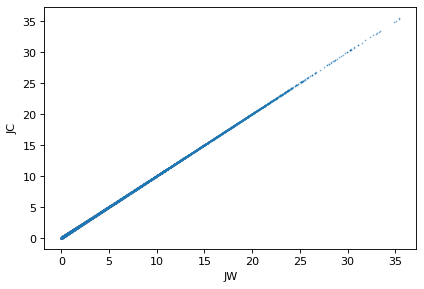

In [231]:
plt.scatter(dat1, dat2, s=0.1)
plt.xlabel("JW")
plt.ylabel("JC")
print(spearmanr(dat1, dat2, nan_policy="omit"))
print(pearsonr(dat1, dat2))

In [95]:
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in ExpMat2.columns.values:
        dat1.append(ExpMat1.loc[g, str_])
        dat2.append(ExpMat3.loc[g, str_])

In [194]:
#plt.scatter(dat1, dat2)
#print(spearmanr(dat1, dat2, nan_policy="omit"))

In [243]:
JonLog = pd.read_csv("dat/Jon_data/expression_energy-human-connectome_struc-log2.csv", index_col=0)
JonLogQN = pd.read_csv("dat/Jon_data/expression_energy-human-connectome_struc-log2-qn.csv", index_col=0)


In [244]:
ExpMat2 = ExpMat1.copy(deep=True)
#ExpMat2 = Jon_ExpMat.copy(deep=True)
for c in ExpMat1.columns.values:
    ExpMat2[c] = np.log2(1+ExpMat2[c])
ExpMat2 = quantileNormalize(ExpMat2)
ExpMat2.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/JW_ExpMat.ArithmeticMean.qn.0418.csv")


SpearmanrResult(correlation=0.9865312594947961, pvalue=0.0)
(0.9852275380462752, 0.0)


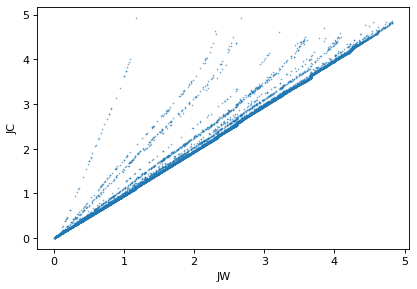

In [245]:
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in JonLogQN.columns.values:
        x1 = ExpMat2.loc[g, str_]
        x2 = JonLogQN.loc[g, str_]
        if x1 == x1 and x2 == x2:
            dat1.append(x1)
            dat2.append(x2)
plt.scatter(dat1, dat2, s=0.1)
plt.xlabel("JW")
plt.ylabel("JC")
print(spearmanr(dat1, dat2, nan_policy="omit"))
print(pearsonr(dat1, dat2))

# Expression Zscore

In [253]:
Genes = JW_ExpMat_genes.intersection(Jon_ExpMat_genes)
Genes = np.array(list(Genes))
print(len(Genes))

17180


In [254]:
#exp_level = pd.read_csv("../dat/allen-mouse-exp/jon/exp_level-before_norm.csv", 
#                           index_col="ROW")
ExpMat = pd.read_csv("dat/jon_data/expression_energy-human-connectome_struc-log2-qn.csv", 
                           index_col="ROW")
ExpMat = ExpMat.loc[Genes,:]
#ExpMat = pd.read_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.0418.csv", 
#                           index_col=0)

In [255]:
#ExpMat_Log = ExpMat.copy(deep=True)
#for c in ExpMat.columns.values:
#    ExpMat[c] = np.log2(1+ExpMat_Log[c])
#ExpMat_Log_QN = quantileNormalize(ExpMat)
#ExpMat_Log.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_exp_mat.log2.0418.csv")


In [256]:
df_z = []
for i in ExpMat.index.values :
    i_z = ZscoreConverting(ExpMat.loc[i,:].values)
    df_z.append(i_z)
ExpZscoreMat = pd.DataFrame(data=df_z, 
                            columns=ExpMat.columns.values, 
                            index=ExpMat.index.values)

ExpZscoreMat.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/AllenMouse_z1_mat.0511.csv")


In [320]:
ExpMat_Log_QN = quantileNormalize(ExpMat_Log)
df_z = []
for i in ExpMat_Log_QN.index.values :
    i_z = ZscoreConverting(ExpMat_Log_QN.loc[i,:].values)
    df_z.append(i_z)
ExpZscoreMat2 = pd.DataFrame(data=df_z, 
                            columns=ExpMat_Log_QN.columns.values, 
                            index=ExpMat_Log_QN.index.values)
ExpZscoreMat2.to_csv("/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/jw_z1_mat.qn.0418.csv")




In [321]:
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in ExpZscoreMat2.columns.values:
        x1 = ExpZscoreMat.loc[g, str_]
        x2 = ExpZscoreMat2.loc[g, str_]
        if x1 == x1 and x2 == x2:
            dat1.append(x1)
            dat2.append(x2)
        #if g == 6658:

SpearmanrResult(correlation=0.7164547562477949, pvalue=0.0)
(0.6811378420288605, 0.0)


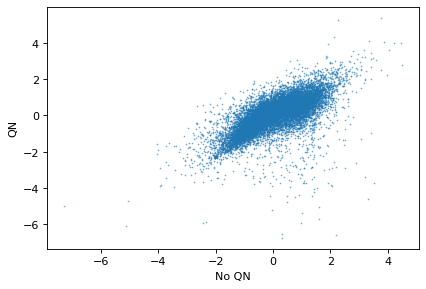

In [322]:
plt.scatter(dat1, dat2, s=0.1)
plt.xlabel("No QN")
plt.ylabel("QN")
print(spearmanr(dat1, dat2, nan_policy="omit"))
print(pearsonr(dat1, dat2))

### Combine Z2 Matrix

In [264]:
Z2_split_dir = "/Users/jiayao/Work/ASD_Circuits/dat/allen-mouse-exp/Mouse.Mean.UniformKernel.Z2scores/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/AllenMouseBrain_Z2bias.csv")

In [2]:
Z2_split_dir = "../dat/AllenMouse.BrainSpanMatch.Z2scores/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("../dat/allen-mouse-exp/AllenMouseBrain_Z2bias.brainspanMatch.csv")

SpearmanrResult(correlation=0.9894225904935373, pvalue=0.0)
(0.9896886583020557, 0.0)


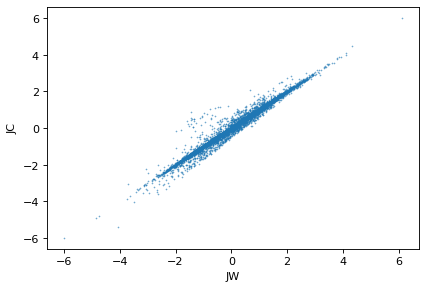

In [266]:
JC_Z2 = pd.read_csv("dat/Jon_data/exp_bias.csv", index_col=0)
dat1, dat2 = [], []
for g in ASD_Genes:
    for str_ in JC_Z2.columns.values:
        x1 = Z2_MAt.loc[g, str_]
        x2 = JC_Z2.loc[g, str_]
        if x1 == x1 and x2 == x2:
            dat1.append(x1)
            dat2.append(x2)
plt.scatter(dat1, dat2, s=0.1)
plt.xlabel("JW")
plt.ylabel("JC")
print(spearmanr(dat1, dat2, nan_policy="omit"))
print(pearsonr(dat1, dat2))

In [3]:
# Z2 Mat with neuron norm

Z2_split_dir = "../dat/AllenMouse.NeuroNorm.Z2score/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("../dat/allen-mouse-exp/AllenMouseBrain_Z2bias.neuronorm.csv")

### Bias calculate, Z2 on the fly with Z1 Matrix

In [273]:
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]
Spark_Meta_ExomeWide.shape

(61, 67)

In [278]:
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights2(Spark_Meta_ExomeWide, 
          allen_mouse_genes = ExpMat.index.values, 
          out = "dat/bias2/Spark_Meta_EWS.GeneWeight.csv")
len(Agg_gene2MutN)

60

##### calculate with match on the fly

In [322]:
Match_DIR = "dat/gene_matches-remap_homolog"
Agg_Match = MakeMatchDF(Agg_gene2MutN, N=1000, DIR=Match_DIR)
Agg_Match.to_csv("dat/bias2/New.Spark_Meta_EWS.Matches.csv")
Agg_Match.shape

dat/gene_matches-remap_homolog/10847.txt
10847 Not Found in Dataset


(59, 1000)

In [323]:
ASD_EW_exp = AvgSTRZ_Weighted(ExpZscoreMat, Agg_gene2MutN, Method = 2, Match_DF = Agg_Match,
                                              csv_fil = "dat/bias2/New.ASD.EW.pLI.expL.csv")


In [324]:
RD_Agg_avgZ_RD = RegionDistributions(ASD_EW_exp.set_index("STR"), show=True, topN=50)

Thalamus 	 7 	 Nucleus_of_reuniens; Parafascicular_nucleus; Submedial_nucleus_of_the_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Parataenial_nucleus; Subparafascicular_nucleus_magnocellular_part
Midbrain 	 2 	 Anterior_pretectal_nucleus; Nucleus_of_the_posterior_commissure
Hippocampus 	 6 	 Field_CA1; Dentate_gyrus; Subiculum_ventral_part; Field_CA2; Field_CA3; Subiculum_dorsal_part
Pallidum 	 1 	 Bed_nuclei_of_the_stria_terminalis
Amygdalar 	 4 	 Intercalated_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Lateral_amygdalar_nucleus; Central_amygdalar_nucleus
Striatum 	 5 	 Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_rostral_rostroventral_part; Lateral_septal_nucleus_caudal_caudodorsal_part
Isocortex 	 20 	 Prelimbic_area; Orbital_area_lateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Anteromedial_visual_area; Primary_visual_area; Anterior_ci

##### calculate with pre-compute z2

In [279]:
ASD_EW_exp = AvgSTRZ_Weighted(Z2_MAt, Agg_gene2MutN, Method = 1,
                               csv_fil = "dat/bias2/Spark_Meta_EWS.Z2.bias.csv")

In [280]:
RD_Agg_avgZ_RD = RegionDistributions(ASD_EW_exp.set_index("STR"), show=True, topN=50)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Cortical_subplate 	 3 	 Claustrum; Endopiriform_nucleus_dorsal_part; Endopiriform_nucleus_ventral_part
Thalamus 	 8 	 Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Subparafascicular_nucleus_magnocellular_part; Mediodorsal_nucleus_of_thalamus
Pallidum 	 1 	 Bed_nuclei_of_the_stria_terminalis
Hippocampus 	 6 	 Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Field_CA3; Parasubiculum
Striatum 	 5 	 Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_rostral_rostroventral_part; Lateral_septal_nucleus_caudal_caudodorsal_part
Amygdalar 	 3 	 Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Intercalated_amygdalar_nucleus
Isocortex 	 20 	 Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromed

In [277]:
ASD_EW_exp.head(30)

,STR,EFFECT,REGION,Rank
0,Nucleus_accumbens,0.504843,Striatum,1
1,Orbital_area_lateral_part,0.502925,Isocortex,2
2,Prelimbic_area,0.497309,Isocortex,3
3,Primary_somatosensory_area_lower_limb,0.467266,Isocortex,4
4,Orbital_area_ventrolateral_part,0.464161,Isocortex,5
5,Parafascicular_nucleus,0.459904,Thalamus,6
6,Lateral_amygdalar_nucleus,0.450113,Amygdalar,7
7,Claustrum,0.446213,Cortical_subplate,8
8,Endopiriform_nucleus_dorsal_part,0.435461,Cortical_subplate,9
9,Infralimbic_area,0.433350,Isocortex,10


In [331]:
asd_bias_z2_qn_nn = pd.read_csv("dat/bias2/New.ASD.EW.Z2.qn.nn.csv", index_col="STR")
asd_bias_z2_qn = pd.read_csv("dat/bias2/New.ASD.EW.Z2.qn.csv", index_col="STR")

In [324]:
g = LoadConnectome2()
topNs = list(range(200, 10, -5))
EWE, EWP = CohesivenessProfile(asd_bias, topNs=topNs, g=g)
PlotCohesivenessProfile(topNs, EWE)

In [332]:
PlotCohesivenessProfile(topNs, EWE, savefig="test")

In [326]:
EWP

[0.7302697302697303,
 0.15084915084915085,
 0.014985014985015033,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.0009990009990009652,
 0.009990009990009985,
 0.07492507492507494,
 0.014985014985015033]